In [ ]:
# please download data from 
# https://github.com/Jakobovski/free-spoken-digit-dataset.git

In [1]:
import numpy as np
import os 
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 

## Data preprocessing

In [ ]:
def pad(data, length):
    if data.shape[1] > length:
        return data[:, 0: length]
    else: 
        padding = np.zeros((data.shape[0], length - data.shape[1]))
        return np.hstack((data, padding))

In [3]:
X = []
y = []
train_X = []
train_y = []
test_X = []
test_y = []

DATA_DIR = "data/recordings"
for fname in os.listdir(DATA_DIR):
    struct = fname.split('_')
    digit = int(struct[0])
    speaker_name = struct[1]
    wav, sr = librosa.load(os.path.join(DATA_DIR, fname))
    wav = librosa.stft(wav) # short-time fourier transform
    wav = np.abs(wav) # only take the real value of complex number
    wav = pad(wav, 25) # 25 is selected manually
    wav = librosa.amplitude_to_db(wav) # amplitude to decibel
    if speaker_name == 'theo': # 5 speaker for train and 1 speaker for test
        test_X.append(wav)
        test_y.append(digit)
    else:
        train_X.append(wav)
        train_y.append(digit)
    X.append(wav)
    y.append(digit)

X = np.array(X)
X = X[..., np.newaxis]
y = np.array(y)

train_X = np.array(train_X)
train_X = train_X[..., np.newaxis]

# one hot encoding
temp_train_y = np.array(train_y)
train_y = np.zeros((temp_train_y.size, temp_train_y.max()+1))
train_y[np.arange(temp_train_y.size), temp_train_y] = 1

test_X = np.array(test_X)
test_X = test_X[..., np.newaxis]

# one hot encoding
temp_test_y = np.array(test_y)
test_y = np.zeros((temp_test_y.size, temp_test_y.max()+1))
test_y[np.arange(temp_test_y.size), temp_test_y] = 1
print('X:', X.shape)
print('y:', y.shape)

X: (3000, 1025, 25, 1)
y: (3000,)


## Model

In [8]:
inp = tf.keras.layers.Input(shape=train_X[0].shape)
x = tf.keras.layers.Conv2D(128, 3, 
                           activation='relu')(inp)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(256, 3, 
                           activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(512, 3, 
                           activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inp, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1025, 25, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1023, 23, 128)     1280      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 511, 11, 128)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 509, 9, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 254, 4, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 252, 2, 512)       1180

## Training

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(train_X, train_y,
                      epochs=30, batch_size=32,
                      validation_data=(test_X, test_y))

Epoch 1/30
79/79 [==============================] - 6s 63ms/step - loss: 3.0391 - accuracy: 0.4208 - val_loss: 1.6776 - val_accuracy: 0.4760
Epoch 2/30
79/79 [==============================] - 4s 55ms/step - loss: 0.6948 - accuracy: 0.7560 - val_loss: 1.5382 - val_accuracy: 0.5100
Epoch 3/30
79/79 [==============================] - 4s 55ms/step - loss: 0.4171 - accuracy: 0.8556 - val_loss: 1.6690 - val_accuracy: 0.3700
Epoch 4/30
79/79 [==============================] - 4s 55ms/step - loss: 0.3348 - accuracy: 0.8932 - val_loss: 1.2030 - val_accuracy: 0.5640
Epoch 5/30
79/79 [==============================] - 4s 55ms/step - loss: 0.3076 - accuracy: 0.9040 - val_loss: 1.2464 - val_accuracy: 0.5440
Epoch 6/30
79/79 [==============================] - 4s 56ms/step - loss: 0.2370 - accuracy: 0.9236 - val_loss: 1.3331 - val_accuracy: 0.5420
Epoch 7/30
79/79 [==============================] - 4s 55ms/step - loss: 0.2265 - accuracy: 0.9232 - val_loss: 1.2623 - val_accuracy: 0.5320
Epoch 8/30
79

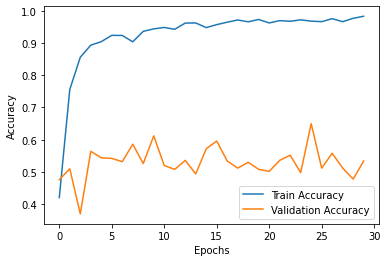

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()